In [4]:
import matplotlib.pyplot as plt

### Reading data

In [5]:
import numpy as np
from sclibrary import read_csv, get_coordinates
from sclibrary import SCPlot


data_folder = 'data/paper_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = read_csv(filename=filename, delimeter=delimeter, src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)
sc = G.to_simplicial_complex(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# if coordinates exist
filename = data_folder + '/coordinates.csv'
coordinates = get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")

# create a plot
scplot = SCPlot(sc, coordinates)

### Chebyshev filter design

In [6]:
from sclibrary.utils.eigendecomposition import get_eigendecomposition

L1 = sc.hodge_laplacian_matrix(rank=1)
L1L = sc.lower_laplacian_matrix(rank=1)

# gradient
U, eigenvals = get_eigendecomposition(L1)
U_l, eigenvals_l = get_eigendecomposition(L1L)

U_H, eigenvals_h = sc.get_eigendecomposition(component="harmonic")
U_G, eigenvals_g = sc.get_eigendecomposition(component="gradient")

In [7]:
# f = np.array([
#     0.0323,
#     0.4980,
#     2.3825,
#     0.8799,
#     -0.5297,
#     -0.5192,
#     1.0754,
#     0.4732,
#     -1.1667,
#     0.0922
# ])
f = np.array([2.90, 0.25, 1.78, -1.50, 1.76, 1.53, 1.32, 0.08, 0.67, 1.73])

In [8]:
_, _, f_g = sc.get_hodgedecomposition(flow=f, round_fig=False)
f_g

array([ 2.47873418,  0.55746835,  1.89379747, -1.92126582,  1.33632911,
        1.83987342,  1.01012658, -0.50658228,  0.94670886,  1.45329114])

In [9]:
# approx largest true eigenvalue using power iteration method
# power iteration
v = np.ones(L1L.shape[0])
for i in range(50):
    v = L1L @ v
    v = v / np.linalg.norm(v)

print("v", v)
# mean of the largest eigenvalue
lamda_g_max = np.mean(L1L @ v / v)
print("lamda_g_max", lamda_g_max)

v [ 0.05882426 -0.32941538  0.14631812 -0.38823965  0.4757335   0.49026405
 -0.30516876  0.31969932  0.12266404 -0.19703528]
lamda_g_max 5.4879826825028015


In [10]:
from chebpy import chebfun

# build the continuos subcomponent extraction function

# cut off frequency - gradient
cut_off_freq_g = 0.01
steep = 100

# logistic function to perform gradient component extraction
g_g = lambda lam: 1 / (1 + np.exp(-steep * (lam - cut_off_freq_g)))

# TODO: do for other components
# for curl cmax function
# for gradient, 1 -

g_g_cheb = chebfun(g_g, [0, lamda_g_max], 10)

# filter coefficients of the gradient component
coeffs_g = g_g_cheb.funs[0].coeffs
coeffs_g

array([ 0.95938561,  0.08122877, -0.08122876,  0.08122875, -0.08122874,
        0.08122872, -0.08122871,  0.0812287 , -0.08122869,  0.04061435])

Text(0.5, 1.0, 'Frequency response on the gradient eigenvals vs chebyshev approx')

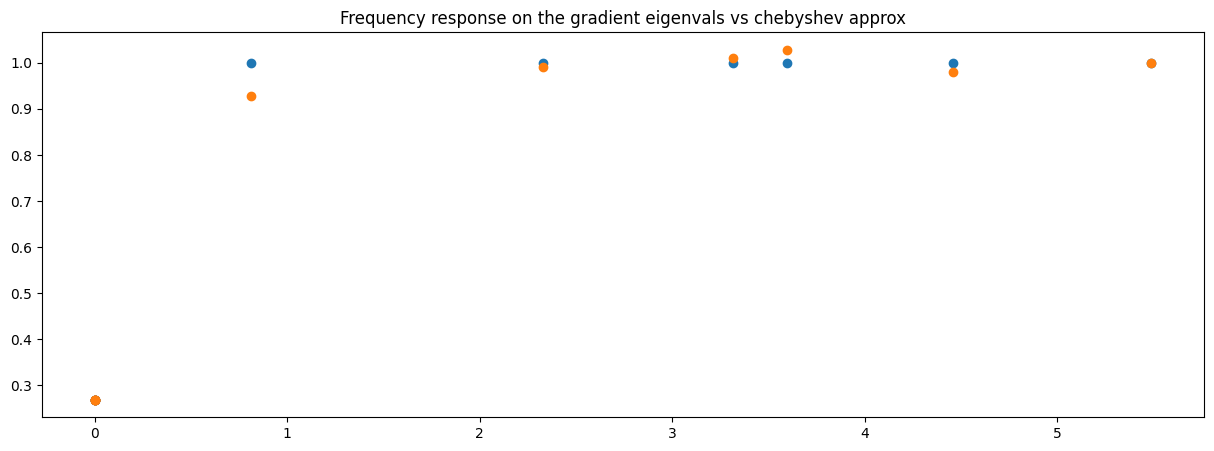

In [11]:
# plot the continuous frequency response 

plt.figure(figsize=(15, 5))
# gradient eigenvalues
plt.scatter(eigenvals_l, g_g(eigenvals_l))
# chebyshev approx
plt.scatter(eigenvals_l, g_g_cheb(eigenvals_l))
plt.title("Frequency response on the gradient eigenvals vs chebyshev approx")

difference 1.913538576985806


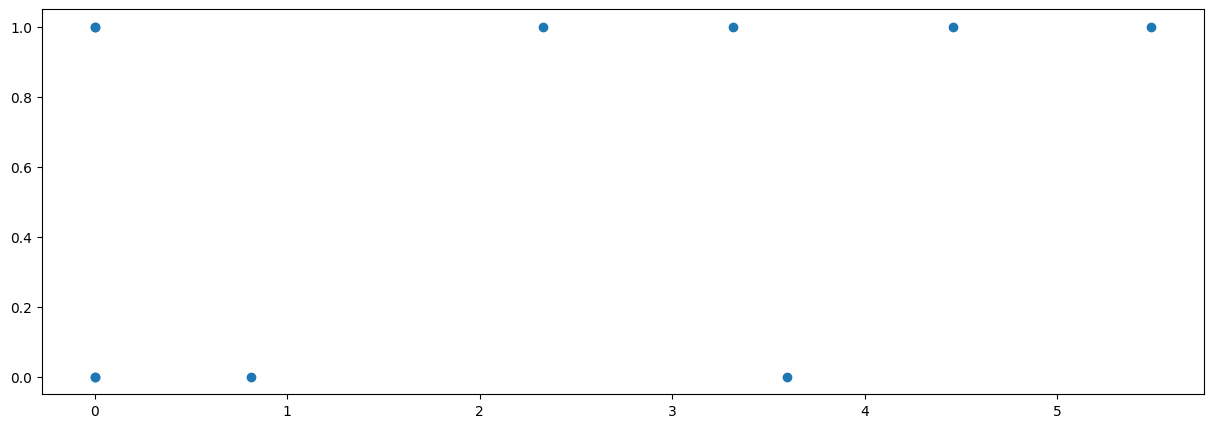

In [12]:

component = "gradient"

# the ideal frequency response
h_g_ideal = sc.get_component_coefficients(component)
H_g_ideal = U_l @ np.diag(h_g_ideal) @ U_l.T
# difference 
print("difference", np.linalg.norm(H_g_ideal - U_G @ U_G.T))

# pplo the ideal frequency response
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_l, h_g_ideal)

In [13]:
# perform a transformation to shit the domain to [0, lambda_g_max]
alpha_g = lamda_g_max / 2
points = (eigenvals_l - alpha_g) / alpha_g
alpha_g

2.7439913412514008

In [14]:
def chebyshev_filter_approximate(laplacian_matrix, coefficients, alpha, k_trnc):
    coeffs = np.array(coefficients[:k_trnc])
    K = len(coeffs)
    
    I = np.eye(laplacian_matrix.shape[0])
    H_cheb_approx = np.zeros((k_trnc, laplacian_matrix.shape[0], laplacian_matrix.shape[1]))
    
    for k in range(K):
        if k == 0:
            H_cheb_approx[k, :, :] = I
        elif k == 1:
            H_cheb_approx[k, :, :] = 1 / alpha * (laplacian_matrix - alpha * I)
        else:
            H_cheb_approx[k, :, :] = 2 / alpha * (laplacian_matrix - alpha * I) @ H_cheb_approx[k - 1, :, :] - H_cheb_approx[k - 2, :, :]
    
    H_cheb_approx_out = np.sum(coeffs[:, np.newaxis, np.newaxis] * H_cheb_approx, axis=0)
    # multiply coefficients and sum on axis 
    return H_cheb_approx_out

In [16]:
import numpy as np

# truncated order 
K_trunc = 10

H_g_cheb_approx_out = np.zeros((K_trunc, L1L.shape[0], L1L.shape[1]))

for k in range(1, K_trunc + 1):
    H_g_cheb_approx_out[k - 1:, :, :] = chebyshev_filter_approximate(L1L, coeffs_g, alpha_g, k) 
    
H_g_cheb_approx_out[0, :, :]

array([[0.95938561, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.95938561, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.95938561, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.95938561, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.95938561,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.95938561, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.95938561, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [17]:
errors_g_response = np.zeros(K_trunc)
errors_filter = np.zeros(K_trunc)

f_g_cheb = np.zeros((L1L.shape[0], K_trunc))
f_g_cheb_tilde = np.zeros((L1L.shape[0], K_trunc))

error_g_tilde = np.zeros(K_trunc)
error_g = np.zeros(K_trunc)


for k in range(K_trunc):
    
    g_g_cheb_approx = np.diag(U_l.T @ np.squeeze(H_g_cheb_approx_out[k, :, :]) @ U_l)
    
    # compute the error with respect to the ideal frequency response
    errors_g_response[k] = np.linalg.norm(g_g_cheb_approx - h_g_ideal) / np.linalg.norm(h_g_ideal)
    errors_filter[k] = np.linalg.norm(np.squeeze(H_g_cheb_approx_out[k, :, :]) - H_g_ideal, 2)
    
    f_g_cheb[:, k] = np.squeeze(H_g_cheb_approx_out[k, :, :]) @ f
    f_g_cheb_tilde[:, k] = U.T @ f_g_cheb[:, k]
    
    error_g_tilde[k] = np.linalg.norm(f_g_cheb_tilde[:, k] - U.T @ f_g) / np.linalg.norm(U.T * f_g)
    error_g[k] = np.linalg.norm(f_g_cheb[:, k] - f_g) / np.linalg.norm(f_g)
    
error_g

array([0.23342434, 0.21653821, 0.19913253, 0.17553209, 0.15657062,
       0.14428483, 0.12338629, 0.10426596, 0.08021398, 0.07385006])

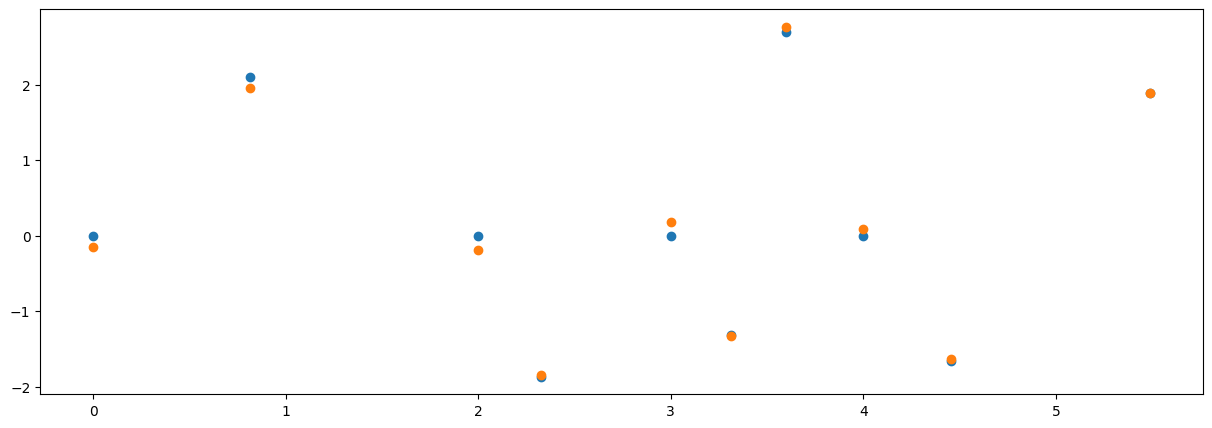

In [18]:
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals, U.T @ f_g)
plt.scatter(eigenvals, f_g_cheb_tilde[:, -1])

In [19]:
error_g

array([0.23342434, 0.21653821, 0.19913253, 0.17553209, 0.15657062,
       0.14428483, 0.12338629, 0.10426596, 0.08021398, 0.07385006])

In [20]:
errors_filter

array([0.95938561, 0.98466898, 1.05015828, 0.98410637, 1.04273537,
       1.09857898, 1.09591095, 1.03631489, 1.01645402, 1.02818114])